In [1]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size':16})

import numpy as np

import sklearn.preprocessing
import sklearn.model_selection

import pycbc.types
import pycbc.waveform
import pycbc.pnutils
import pycbc.conversions

import lal
from scipy.interpolate import InterpolatedUnivariateSpline as IUS

PyCBC.libutils: pkg-config call failed, setting NO_PKGCONFIG=1


In [2]:
import tensorflow as tf
import wispy.callbacks
import tensorflow_addons as tfa

In [3]:
from tf_fourier_features import FourierFeatureProjection

In [4]:
def StoM(S, Mtot):
    """StoM(S, Mtot)
    """
    return S / (lal.MTSUN_SI*Mtot)

def MtoS(M, Mtot):
    """MtoS(Hz, Mtot)
    """
    return M * (lal.MTSUN_SI*Mtot)

def td_amp_scale(mtot, distance):
    """
    mtot in solar masses
    distance in m
    M*G/c^2 * M_sun / dist
    """
    return mtot * lal.MRSUN_SI / distance

In [4306]:
def generate_waveform(new_times_M, mass_ratio=1, total_mass=100, chi=0, approximant="SEOBNRv4_opt", distance_mpc=1):
    
    mass1=pycbc.conversions.mass1_from_mtotal_q(total_mass, mass_ratio)
    mass2=pycbc.conversions.mass2_from_mtotal_q(total_mass, mass_ratio)

    # mass1=pycbc.conversions.mass1_from_mtotal_q(100, 4)
    # mass2=pycbc.conversions.mass2_from_mtotal_q(100, 4)

    # can scale amp by eta
    # eta = pycbc.conversions.eta_from_mass1_mass2(mass1, mass2)

    params = dict(
        # spin1x=mass_ratio,
        mass1=mass1,
        mass2=mass2,
        spin1z=chi,
        spin2z=chi,
        approximant=approximant,
        f_lower=8,
        delta_t=1/4096,
        distance=distance_mpc
        )
    hp, hc = pycbc.waveform.get_td_waveform(**params)
    delta_t = hp.delta_t

    amp = pycbc.waveform.utils.amplitude_from_polarizations(hp, hc).numpy()
    phase = pycbc.waveform.utils.phase_from_polarizations(hp, hc, remove_start_phase=True).numpy()

    times_M = StoM(hp.sample_times.numpy(), total_mass)

    new_amp = IUS(times_M, amp)(new_times_M)

    distance_m = 1e6*distance_mpc*lal.PC_SI
    new_amp /= td_amp_scale(total_mass, distance_m)

    new_phase = IUS(times_M, phase)(new_times_M)
    new_phase += -new_phase[0]

    h = new_amp * np.exp(-1.j * new_phase)
    hp = np.real(h)
    # hc = np.imag(h)

    return hp
    # return new_amp
    # return new_phase

In [4307]:
mass_ratio = 4
# mass_ratio = 0.95
chi=0.99
total_mass = 100
approximant = "SEOBNRv4_opt"
# approximant = "SEOBNRv4P"
distance_mpc = 1


# uniform spacing throughout
# t1 = -1000
t1 = -500
# t1 = -200
# t1 = -2000
# t1 = -5000
# t2 = 100
t2 = 70
dt = 0.5
# dt = 1
# dt = 0.25
# dt = 2
new_times_M = np.arange(t1, t2, dt)

# implement higher sample rate for merger

# # # region 1 inspiral
# # r1_t1 = -500
# r1_t1 = -2000
# r1_t2 = -200
# r1_dt = 4
# # r1_dt = 8
# r1_new_times_M = np.arange(r1_t1, r1_t2, r1_dt)


# # region 2 merger-ringdown
# r2_t1 = r1_t2
# r2_t2 = 70
# # r2_dt = 0.25
# r2_dt = 0.75
# r2_new_times_M = np.arange(r2_t1, r2_t2, r2_dt)

# new_times_M = np.concatenate((r1_new_times_M, r2_new_times_M))



In [4308]:
new_times_M.shape


(1140,)

In [4309]:
hp = generate_waveform(new_times_M=new_times_M, mass_ratio=mass_ratio, total_mass=total_mass, chi=chi, approximant=approximant, distance_mpc=distance_mpc)

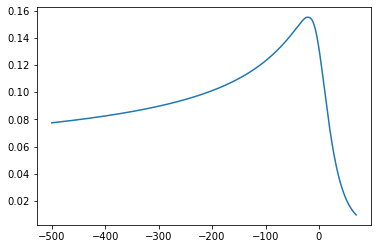

In [4310]:
# plt.plot(StoM(hp.sample_times, total_mass), hp)
plt.plot(new_times_M, hp)

In [4311]:
# qs = np.linspace(3, 5, 2)
# qs = np.linspace(1,2,20)
# qs = np.array([1.])
# qs = np.arange(1, 1.2, 0.01)
qs = np.arange(2, 3, 0.05)
# chis = np.linspace(-0.99, 0.99, 10)
# chis = np.linspace(0.8, 0.99, 40)
# chis = np.linspace(0.8, 0.99, 2)
# chis = np.array([0.])
# chis = np.linspace(0., 0.5, 30)
# chis = np.linspace(0., 0.1, 5)
# chis = np.arange(0., 0.5, 0.01)
chis = np.arange(-0.99, 0.99, 0.45)
# chis = np.arange(0.8, 0.9, 0.01)
# chis = np.arange(0.8, 0.99, 0.005)

# qs = np.linspace(1, 3, 5)
# chis = np.linspace(-0.99, 0.99, 5)


# chis = np.linspace(0.8, 0.99, 30)
# chis_1 = np.linspace(-0.99, 0.5, 10)
# chis_2 = np.linspace(0.5, 0.99, 10)
# chis = np.concatenate((chis_1, chis_2))

XX, YY = np.meshgrid(qs, chis)
XX = XX.ravel()
YY = YY.ravel()

In [4312]:
test_chi_scaler = sklearn.preprocessing.MinMaxScaler(feature_range=(-0.5, 0.5))
test_chi_scaled = test_chi_scaler.fit_transform(chis[:,np.newaxis])[:,0]

In [4313]:
1/(chis[1]-chis[0])

2.2222222222222223

In [4314]:
1/(test_chi_scaled[1]-test_chi_scaled[0])

4.0

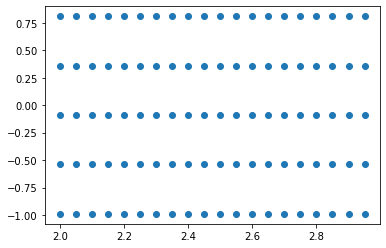

In [4315]:
plt.scatter(XX, YY)

In [4316]:
num_samples = len(XX)

In [4317]:
num_samples

100

In [4318]:
hps = []
for i in range(num_samples):
    mass_ratio = XX[i]
    chi = YY[i]
    hp = generate_waveform(new_times_M=new_times_M, mass_ratio=mass_ratio, chi=chi, total_mass=total_mass, approximant=approximant, distance_mpc=distance_mpc)
    hps.append(hp)
hps = np.array(hps)

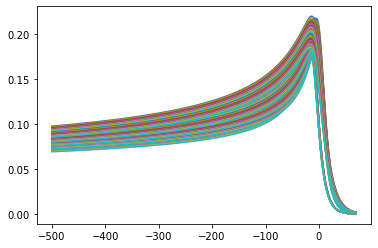

In [4319]:
for hp in hps:
    plt.plot(new_times_M, hp)
# plt.xlim(-100, 100)

In [4320]:
theta = np.column_stack((XX, YY))

In [4321]:
theta_idxs = np.arange(len(theta))


# if you want the training set and validation set to have
# different mass-ratios then uncomment
theta_training_idxs = theta_idxs[::2]


# the next lines are a bit confusing
# but 
# if you do q_idxs[1::2] then the last data point it outside the training set
# so for the training idxs I also add in the last data point
# that would have been totally excluded
theta_training_idxs = np.concatenate((theta_training_idxs, [theta_idxs[-1]]))
theta_validation_idxs = theta_idxs[1:-1:2] 

# use this if you want the train and val sets to have the same mass-ratios
# but they will be using alternating time samples
# theta_training_idxs = theta_idxs
# theta_validation_idxs = theta_idxs

In [4322]:
theta_training_idxs

array([ 0,  2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32,
       34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66,
       68, 70, 72, 74, 76, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 99])

In [4323]:
theta_validation_idxs

array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33,
       35, 37, 39, 41, 43, 45, 47, 49, 51, 53, 55, 57, 59, 61, 63, 65, 67,
       69, 71, 73, 75, 77, 79, 81, 83, 85, 87, 89, 91, 93, 95, 97])

In [4324]:
len(theta_idxs)

100

In [4325]:

len(theta_training_idxs)


51

In [4326]:

len(theta_validation_idxs)

49

In [4327]:
t_idxs = np.arange(len(new_times_M))
t_training_idxs = t_idxs[::2]
t_validation_idxs = t_idxs[1::2]

In [4328]:
len(t_idxs)

1140

In [4329]:
len(t_training_idxs)

570

In [4330]:
len(t_validation_idxs)

570

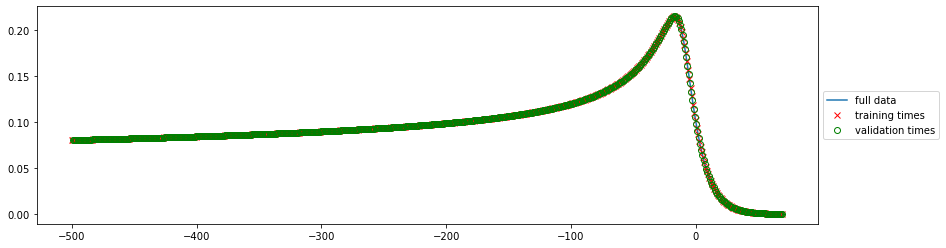

In [4331]:
plt.figure(figsize=(14, 4))
plt.plot(new_times_M, hps[0], label='full data')
plt.plot(new_times_M[t_training_idxs], hps[0][t_training_idxs], 'rx', label='training times')
plt.plot(new_times_M[t_validation_idxs], hps[0][t_validation_idxs], 'go',markerfacecolor='none', label='validation times')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [4332]:
plt.figure(figsize=(14, 4))
plt.plot(new_times_M, hps[0], label='full data')
plt.plot(new_times_M[t_training_idxs], hps[0][t_training_idxs], 'rx', label='training times')
plt.plot(new_times_M[t_validation_idxs], hps[0][t_validation_idxs], 'go',markerfacecolor='none', label='validation times')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlim(-100, 100)

(-100.0, 100.0)

In [4333]:
def build_input_single_q(t, q, chi):
    """
    t is a matrix i.e. shape = (-1, 1)
    q is a float
    chi is a float
    """
    theta = np.array([q, chi])
    theta = np.ones_like(t) * theta

    return np.column_stack((t, theta))

In [4334]:
build_input_single_q(np.array([1,2,3]).reshape(-1, 1), 1, 0.5)

array([[1. , 1. , 0.5],
       [2. , 1. , 0.5],
       [3. , 1. , 0.5]])

In [4335]:
def build_input_multiple_q(t, thetas):
    """
    t is a vector
    thetas is a vector
    """
    return np.row_stack([build_input_single_q(t, *theta) for theta in thetas])

In [4336]:
build_input_multiple_q(np.array([1,2,3]).reshape(-1, 1), [[1,3], [0.5, 0.4]])

array([[1. , 1. , 3. ],
       [2. , 1. , 3. ],
       [3. , 1. , 3. ],
       [1. , 0.5, 0.4],
       [2. , 0.5, 0.4],
       [3. , 0.5, 0.4]])

In [4337]:
theta_1_scaler = sklearn.preprocessing.MinMaxScaler(feature_range=(new_times_M[0], new_times_M[-1]))
theta_1_scaled = theta_1_scaler.fit_transform(theta)

In [4338]:
t_scaler = sklearn.preprocessing.MinMaxScaler(feature_range=(-0.5, 0.5))
t_scaled = t_scaler.fit_transform(new_times_M[:,np.newaxis])

theta_scaler = sklearn.preprocessing.MinMaxScaler(feature_range=(-0.5, 0.5))


theta_scaled = theta_scaler.fit_transform(theta)
# theta_scaled = theta_scaler.fit_transform(theta_1_scaled)

In [4339]:
1/(t_scaled[1]-t_scaled[0])

array([1139.])

In [4340]:
hps_scaler = sklearn.preprocessing.MinMaxScaler(feature_range=(-0.5, 0.5))

hps_shape = hps.shape
hps_scaled = hps_scaler.fit_transform(hps.reshape(-1, 1)).reshape(hps_shape)

In [4341]:
X_training = build_input_multiple_q(t_scaled[t_training_idxs], theta_scaled[theta_training_idxs])

In [4342]:
X_validation = build_input_multiple_q(t_scaled[t_validation_idxs], theta_scaled[theta_validation_idxs])

In [4343]:
X_training.shape

(29070, 3)

In [4344]:
X_validation.shape

(27930, 3)

In [4345]:
hps.shape

(100, 1140)

In [4346]:
# y_training = hps[np.ix_(theta_training_idxs, t_training_idxs)]
# y_training = y_training.reshape(-1, 1)
# y_validation = hps[np.ix_(theta_validation_idxs, t_validation_idxs)]
# y_validation = y_validation.reshape(-1, 1)


# https://stackoverflow.com/questions/35607818/index-a-2d-numpy-array-with-2-lists-of-indices
y_training = hps_scaled[np.ix_(theta_training_idxs, t_training_idxs)]
y_training = y_training.reshape(-1, 1)
y_validation = hps_scaled[np.ix_(theta_validation_idxs, t_validation_idxs)]
y_validation = y_validation.reshape(-1, 1)

In [4347]:
y_training.shape

(29070, 1)

In [4348]:
y_validation.shape

(27930, 1)

In [4349]:
# fig = plt.figure(dpi=120)
# ax = fig.add_subplot(projection='3d')
# ax.scatter(X_training[:,0], X_training[:,2], y_training, s=3)
# ax.scatter(X_validation[:,0], X_validation[:,2], y_validation, s=3)

In [4350]:
def run_model(X_train, y_train, epochs=1001, threshold=1e-7, batch_size=32, validation_data=None, learning_rate=1e-3, verbose=0, model_version="1", validation_batch_size=None):
    activation = 'relu'
    units = 256
    # units = 64
    # units = 512
    # units = 1024
    n_layers = 3
    # n_layers = 6
    # gaussian_projection = units
    gaussian_projection = 16
    # gaussian_projection = 128
    # gaussian_projection = 20
    # gaussian_projection = 5
    # gaussian_scale = 1

    # gaussian_scale = 50
    # gaussian_scale = 20
    # gaussian_scale = 160
    # gaussian_scale = 64
    gaussian_scale = 64/4
    # gaussian_scale = 64+20
    # gaussian_scale = 128
    # gaussian_scale = 200
    # gaussian_scale = 4000
    # gaussian_scale = 160*5
    # gaussian_scale = 5
    # gaussian_scale = 1

    # model 1: only pass the time through the RFF encoding
    time_input = tf.keras.Input(shape=(1,), name='time_input')
    

    x_t = FourierFeatureProjection(gaussian_projection = gaussian_projection, gaussian_scale = gaussian_scale)(time_input)
    
    
    if model_version == "1":
        theta_input = tf.keras.Input(shape=(2,), name='theta_input')
        # x = tf.keras.layers.Concatenate()([x_t, q_input])
        x = tf.keras.layers.Concatenate()([x_t, theta_input])
    elif model_version == "2":
        theta_input = tf.keras.Input(shape=(2,), name='theta_input')
        # x_q = FourierFeatureProjection(gaussian_projection = 5, gaussian_scale = 0.1)(q_input)
        x_theta = FourierFeatureProjection(gaussian_projection = 16*2, gaussian_scale = 100*2*2)(theta_input)
        
        
        x_t = tf.keras.layers.Dense(units, activation)(x_t)
        x_theta = tf.keras.layers.Dense(units, activation)(x_theta)
        
        # x = tf.keras.layers.Concatenate()([x_t, x_q])
        x = tf.keras.layers.Concatenate()([x_t, x_theta])
    elif model_version == "3":
        q_input = tf.keras.Input(shape=(1,), name='q_input')
        chi_input = tf.keras.Input(shape=(1,), name='chi_input')
        # x_q = FourierFeatureProjection(gaussian_projection = 16, gaussian_scale = 1)(q_input)
        # x_chi = FourierFeatureProjection(gaussian_projection = 16*2, gaussian_scale = 4)(chi_input)
        
        
        # x_t = tf.keras.layers.Dense(units, activation)(x_t)
        # x_t = tf.keras.layers.Dense(units, activation)(x_t)
        # x_t = tf.keras.layers.Dense(units, activation)(x_t)
        # x_q = tf.keras.layers.Dense(units, activation)(q_input)
        # x_chi = tf.keras.layers.Dense(units, activation)(x_chi)
        # x_chi = tf.keras.layers.Dense(units, activation)(chi_input)
        
        # x = tf.keras.layers.Concatenate()([x_t, x_q, x_chi])
        x = tf.keras.layers.Concatenate()([x_t, q_input, chi_input])
    elif model_version == "4":
        q_input = tf.keras.Input(shape=(1,), name='q_input')
        chi_input = tf.keras.Input(shape=(1,), name='chi_input')
        x = tf.keras.layers.Dense(units, activation)(x_t)
    else:
        raise ValueError()
    
    # x_q = tf.keras.layers.Dense(units, activation)(q_input)

    for i in range(n_layers):
        x = tf.keras.layers.Dense(units, activation)(x)
        # x = tf.keras.layers.Dense(units*(i+1), activation)(x)
    if model_version == "4":
        x_q = tf.keras.layers.Dense(units, activation)(q_input)
        x_chi = tf.keras.layers.Dense(units, activation)(chi_input)
        # x = tf.keras.layers.Concatenate()([x, q_input, chi_input])
        x = tf.keras.layers.Concatenate()([x, x_q, x_chi])
        x = tf.keras.layers.Dense(units, activation)(x)
        x = tf.keras.layers.Dense(units, activation)(x)
    x = tf.keras.layers.Dense(1)(x)
    
    if model_version in ["3", "4"]:
        model = tf.keras.Model(inputs=[time_input, q_input, chi_input], outputs=x)
    else:
        model = tf.keras.Model(inputs=[time_input, theta_input], outputs=x)

    # model 2: pass both time and mass-ratio through RFF encoding
    # model 2 doesn't work so well in the q-direction :)
    # I am guessing it's because the variation of the function in q
    # is simpler than the variation in time.
    # time_input = tf.keras.Input(shape=(1,), name='time_input')
    # q_input = tf.keras.Input(shape=(1,), name='q_input')
    # all_inputs = tf.keras.layers.Concatenate()([time_input, q_input])
    # x = FourierFeatureProjection(gaussian_projection = gaussian_projection, gaussian_scale = gaussian_scale)(all_inputs)
    # # x_q = tf.keras.layers.Dense(units, activation)(q_input)
    # # x = tf.keras.layers.Concatenate()([x_t, q_input])
    # # x = tf.keras.layers.Concatenate()([x_t, x_q])
    # for i in range(n_layers):
    #     x = tf.keras.layers.Dense(units, activation)(x)
    # x = tf.keras.layers.Dense(1)(x)
    # model = tf.keras.Model(inputs=[time_input, q_input], outputs=x)
    
    callbacks = [
        # tfa.callbacks.TQDMProgressBar(show_epoch_progress=False),
        wispy.callbacks.ThresholdCallback(threshold),
        # tf.keras.callbacks.ReduceLROnPlateau(min_lr=1e-6, patience=200, factor=0.9, monitor='val_loss'),
        # tf.keras.callbacks.ReduceLROnPlateau(min_lr=1e-6, patience=200, factor=0.6, monitor='val_loss'),
        # tf.keras.callbacks.ReduceLROnPlateau(min_lr=1e-6, patience=200, factor=0.6, monitor='val_loss'),        
        # tf.keras.callbacks.ReduceLROnPlateau(min_lr=1e-6, patience=50, factor=0.5, monitor='loss'),
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=300),
    ]
    
    model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate))
    
    print(model.summary())

    if model_version in ["3", "4"]:
        history = model.fit(x=[X_train[:,0], X_train[:,1], X_train[:,2]], y=y_train, epochs=epochs, verbose=verbose, batch_size=batch_size, callbacks=callbacks, validation_data=validation_data, validation_batch_size=validation_batch_size) 
    else:
        history = model.fit(x=[X_train[:,0], X_train[:,1:]], y=y_train, epochs=epochs, verbose=verbose, batch_size=batch_size, callbacks=callbacks, validation_data=validation_data, validation_batch_size=validation_batch_size)
    
    return history, model

In [4351]:
def run_simple_model(X_train, y_train, epochs=1001, threshold=1e-7, batch_size=32, validation_data=None, learning_rate=1e-3, verbose=0, model_version="1", validation_batch_size=None):
    activation = 'relu'
    units = 256
    # units = 64
    # units = 512
    # units = 1024
    n_layers = 3
    # n_layers = 6
    # gaussian_projection = units
    gaussian_projection = 16
    # gaussian_projection = 128
    # gaussian_projection = 20
    # gaussian_projection = 5
    # gaussian_scale = 1

    # gaussian_scale = 50
    # gaussian_scale = 20
    # gaussian_scale = 160
    # gaussian_scale = 64
    gaussian_scale = 64/4
    # gaussian_scale = 64+20
    # gaussian_scale = 128
    # gaussian_scale = 200
    # gaussian_scale = 4000
    # gaussian_scale = 160*5
    # gaussian_scale = 5
    # gaussian_scale = 1

    # model 1: only pass the time through the RFF encoding
    time_input = tf.keras.Input(shape=(1,))
    q_input = tf.keras.Input(shape=(1,))
    chi_input = tf.keras.Input(shape=(1,))
    x_t = FourierFeatureProjection(gaussian_projection = gaussian_projection, gaussian_scale = gaussian_scale)(time_input)
    x_q = FourierFeatureProjection(gaussian_projection = gaussian_projection, gaussian_scale = gaussian_scale/10)(q_input)
    x_chi = FourierFeatureProjection(gaussian_projection = gaussian_projection, gaussian_scale = gaussian_scale)(chi_input)
    
    x = tf.keras.layers.Concatenate()([x_t, x_q, x_chi])

    for i in range(n_layers):
        x = tf.keras.layers.Dense(units, activation)(x)
    x = tf.keras.layers.Dense(1)(x)
    
    model = tf.keras.Model(inputs=[time_input, q_input, chi_input], outputs=x)

    # model 2: pass both time and mass-ratio through RFF encoding
    # model 2 doesn't work so well in the q-direction :)
    # I am guessing it's because the variation of the function in q
    # is simpler than the variation in time.
    # time_input = tf.keras.Input(shape=(1,), name='time_input')
    # q_input = tf.keras.Input(shape=(1,), name='q_input')
    # all_inputs = tf.keras.layers.Concatenate()([time_input, q_input])
    # x = FourierFeatureProjection(gaussian_projection = gaussian_projection, gaussian_scale = gaussian_scale)(all_inputs)
    # # x_q = tf.keras.layers.Dense(units, activation)(q_input)
    # # x = tf.keras.layers.Concatenate()([x_t, q_input])
    # # x = tf.keras.layers.Concatenate()([x_t, x_q])
    # for i in range(n_layers):
    #     x = tf.keras.layers.Dense(units, activation)(x)
    # x = tf.keras.layers.Dense(1)(x)
    # model = tf.keras.Model(inputs=[time_input, q_input], outputs=x)
    
    callbacks = [
        # tfa.callbacks.TQDMProgressBar(show_epoch_progress=False),
        wispy.callbacks.ThresholdCallback(threshold),
        # tf.keras.callbacks.ReduceLROnPlateau(min_lr=1e-6, patience=200, factor=0.9, monitor='val_loss'),
        # tf.keras.callbacks.ReduceLROnPlateau(min_lr=1e-6, patience=200, factor=0.6, monitor='val_loss'),
        # tf.keras.callbacks.ReduceLROnPlateau(min_lr=1e-6, patience=200, factor=0.6, monitor='val_loss'),        
        # tf.keras.callbacks.ReduceLROnPlateau(min_lr=1e-6, patience=50, factor=0.5, monitor='loss'),
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=300),
    ]
    
    model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate))
    
    print(model.summary())

    history = model.fit(x=[X_train[:,0], X_train[:,1], X_train[:,2]], y=y_train, epochs=epochs, verbose=verbose, batch_size=batch_size, callbacks=callbacks, validation_data=validation_data, validation_batch_size=validation_batch_size)
    
    return history, model

In [4352]:
X_training.shape

(29070, 3)

In [4353]:
len(X_training)//5

5814

In [4354]:
epochs=200
# epochs=2000
# batch_size = 128
batch_size = 512
# batch_size = 1024
# batch_size = 2048
# batch_size = 4096
# batch_size = 8192
# batch_size = 130560
# batch_size = len(X_training)//5
# batch_size = len(X_training)//20

validation_batch_size=8192
print(batch_size)

# learning_rate = 1e-2
learning_rate = 1e-3
# learning_rate = 1e-4
print(learning_rate)

512
0.001


In [4355]:
# model_version="1"
# model_version="2"
model_version="3"
# model_version="4"

In [4356]:
%%time
# history, model = run_model(
#     X_training,
#     y_training,
#     epochs=epochs,
#     batch_size=batch_size,
#     # validation_data=([X_validation[:,0], X_validation[:,1:]], y_validation),
#     validation_data=([X_validation[:,0], X_validation[:,1], X_validation[:,2]], y_validation),
#     # validation_data=None,
#     learning_rate=learning_rate,
#     threshold=4e-6,
#     verbose=1,
#     model_version=model_version,
#     validation_batch_size=validation_batch_size,
#     # threshold=3e-6
#     )

history, model = run_simple_model(
    X_training,
    y_training,
    epochs=epochs,
    batch_size=batch_size,
    # validation_data=(X_validation, y_validation),
    validation_data=([X_validation[:,0], X_validation[:,1], X_validation[:,2]], y_validation),
    # validation_data=None,
    learning_rate=learning_rate,
    threshold=4e-6,
    verbose=1,
    model_version=model_version,
    validation_batch_size=validation_batch_size,
    # threshold=3e-6
    )

Model: "model_168"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_26 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 input_27 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 input_28 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 fourier_feature_projection_323  (None, 32)          16          ['input_26[0][0]']               
  (FourierFeatureProjection)                                                              

2022-06-19 14:31:26.895701: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


57/57 [==============================] - ETA: 0s - loss: 0.0134

2022-06-19 14:31:28.013649: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


57/57 [==============================] - 2s 18ms/step - loss: 0.0134 - val_loss: 0.0016
Epoch 2/200
57/57 [==============================] - 1s 9ms/step - loss: 7.3520e-04 - val_loss: 7.7999e-04
Epoch 3/200
57/57 [==============================] - 1s 9ms/step - loss: 3.3157e-04 - val_loss: 6.1026e-04
Epoch 4/200
57/57 [==============================] - 1s 9ms/step - loss: 1.9771e-04 - val_loss: 5.3503e-04
Epoch 5/200
57/57 [==============================] - 1s 9ms/step - loss: 1.3413e-04 - val_loss: 4.9965e-04
Epoch 6/200
57/57 [==============================] - 1s 10ms/step - loss: 9.9009e-05 - val_loss: 4.6815e-04
Epoch 7/200
57/57 [==============================] - 1s 9ms/step - loss: 7.4056e-05 - val_loss: 4.5336e-04
Epoch 8/200
57/57 [==============================] - 1s 10ms/step - loss: 6.0027e-05 - val_loss: 4.4903e-04
Epoch 9/200
57/57 [==============================] - 0s 8ms/step - loss: 4.7364e-05 - val_loss: 4.4382e-04
Epoch 10/200
57/57 [==============================] - 

KeyboardInterrupt: 

In [4357]:
plt.figure()
plt.plot(history.history["loss"], label='loss')
plt.plot(history.history["val_loss"], label='val_loss')
plt.legend()
plt.axhline(1e-5)
plt.axhline(1e-6)
plt.axhline(3e-6, c='k')
plt.axhline(1e-7)
plt.yscale("log")

In [4358]:
plt.figure()
plt.plot(history.history["loss"], label='loss')
plt.plot(history.history["val_loss"], label='val_loss')
plt.legend()
plt.yscale("log")
plt.xscale("log")

In [4359]:
try:
    plt.figure()
    plt.plot(history.history["lr"], label='lr')
    plt.legend()
    plt.yscale("log")
    # plt.xscale("log")
except:
    pass

<Figure size 432x288 with 0 Axes>

In [4360]:
model.summary()

Model: "model_164"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_14 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 input_15 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 input_16 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 fourier_feature_projection_311  (None, 32)          16          ['input_14[0][0]']               
  (FourierFeatureProjection)                                                              

In [4361]:
# tf.keras.utils.plot_model(model, show_shapes=True, rankdir='LR')

In [4362]:
# model.layers[1].weights[0]

In [4363]:
# w=model.layers[1].weights[0].numpy()[0]
# plt.scatter(range(len(w)), w)

In [4364]:
theta[theta_validation_idxs[-1]]

array([2.85, 0.81])

In [4365]:
theta[theta_training_idxs[-1]]

array([2.95, 0.81])

In [4366]:
# test_input = build_input_single_q(t_scaled, *theta_scaled[theta_validation_idxs[-1]])
test_input = build_input_single_q(t_scaled, *theta_scaled[theta_training_idxs[-1]])
# test_yhat = model.predict([test_input[:,0], test_input[:,1:]], verbose=0)
test_yhat = model.predict([test_input[:,0], test_input[:,1], test_input[:,2]], verbose=0)
# test_yhat = model.predict(test_input, verbose=0)

In [4367]:
test_input.shape

(1140, 3)

In [4368]:
# plt.plot(test_input[:,0], hps_scaled[theta_validation_idxs[-1]])
plt.plot(test_input[:,0], hps_scaled[theta_training_idxs[-1]])
plt.plot(test_input[:,0], test_yhat[:,0], ls='-')
# plt.xlim(0.3, 0.5)
# plt.yscale('log')

In [4369]:
# plt.plot(test_input[:,0], hps_scaled[theta_validation_idxs[-1]])
plt.plot(test_input[:,0], hps_scaled[theta_training_idxs[-1]])
plt.plot(test_input[:,0], test_yhat[:,0], ls='-')
plt.xlim(0.3, 0.5)
# plt.yscale('log')

(0.3, 0.5)

In [4370]:
test_input = build_input_single_q(t_scaled, *theta_scaled[theta_validation_idxs[-1]])
# test_input = build_input_single_q(t_scaled, *theta_scaled[theta_training_idxs[-1]])
# test_yhat = model.predict([test_input[:,0], test_input[:,1:]], verbose=0)
test_yhat = model.predict([test_input[:,0], test_input[:,1], test_input[:,2]], verbose=0)
# test_yhat = model.predict(test_input, verbose=0)

In [4371]:
test_input.shape

/opt/homebrew/Caskroom/miniforge/base/envs/tf/lib/python3.9/site-packages/IPython/core/displayhook.py:275: UserWarning: Output cache limit (currently 1000 entries) hit.
Flushing oldest 200 entries.
  warn('Output cache limit (currently {sz} entries) hit.\n'


(1140, 3)

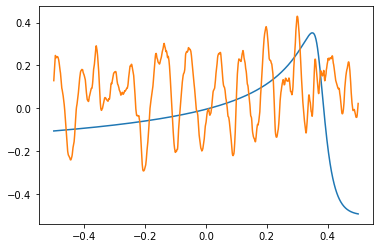

In [4372]:
plt.plot(test_input[:,0], hps_scaled[theta_validation_idxs[-1]])
# plt.plot(test_input[:,0], hps_scaled[theta_training_idxs[-1]])
plt.plot(test_input[:,0], test_yhat[:,0], ls='-')
# plt.xlim(0.3, 0.5)
# plt.yscale('log')

In [4373]:
plt.plot(test_input[:,0], hps_scaled[theta_validation_idxs[-1]])
# plt.plot(test_input[:,0], hps_scaled[theta_training_idxs[-1]])
plt.plot(test_input[:,0], test_yhat[:,0], ls='-')
plt.xlim(0.3, 0.5)
# plt.yscale('log')

(0.3, 0.5)

In [4374]:
# %%timeit
# # model.predict([test_input[:,0], test_input[:,1:]], verbose=0)

# model.predict([test_input[:,0], test_input[:,1], test_input[:,2]], verbose=0)